## Assignment || t-SNE Visualization of Amazon Reviews 
#### By Rishiraj Adikary For AppliedAIcourse.com || www.rishiraj.xyz@gmail.com

## Part 2: 
### Text to Vector Conversion and t-SNE visulization

## Objective
### To say weather a review is positive or negative based on the text 

In [1]:
#initilaization for all the required packages
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
# using the SQLite Table to read data.
#final.sqlite is a cleaned deduped and preprocessed data
con = sqlite3.connect('final.sqlite') 


cleaned_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

positiveNegative = cleaned_data['Score'] #Keeping labels/class in a different variable so that we can use it latercleaned_data.shape
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


### We will have to reduce the data sets from 364K to 2K data sets of which 1K is positive and 1K is negative
#### This is done so as to speed up computation. 

In [3]:
#we will take first 1k positive reviews and first 1k negative reviews. Combine them to have a total of 2k text reviews
positiveData = cleaned_data[cleaned_data['Score'] == 'positive']
negativeData = cleaned_data[cleaned_data['Score'] == 'negative']
cleanedData_less = positiveData[:1000].append(negativeData[:1000])
len(cleanedData_less)
#the score corresponding to all 2k reviews
positiveNegativeLabel = cleanedData_less['Score']

## Text to Vector Conversion Using Bag of Words. 


In [4]:
positiveNegativeLabel = cleanedData_less['Score']
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(cleanedData_less['Text'].values)
final_counts.get_shape()
print(type(final_counts))

<class 'scipy.sparse.csr.csr_matrix'>


In [5]:
#we need to convert the sparse matrix to dataframe before we can apply tSNE on the text vectors
final_DF = pd.DataFrame(final_counts.toarray())
type(final_DF)

pandas.core.frame.DataFrame

##  Applying t-SNE on BOW Vectors

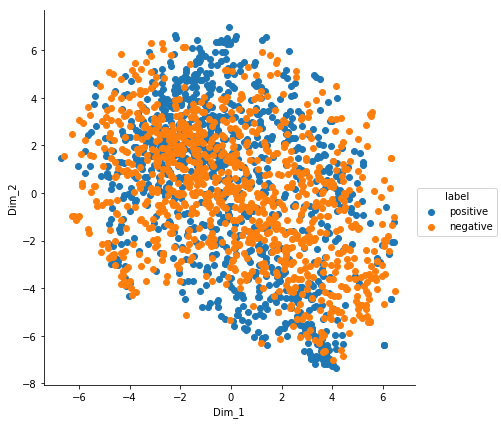

In [10]:
#final_DF: is the first 2000 vector representation of text reviews with 1000 positive and 1000 negative reviews
#positiveNegativeLabel is the label/class for each vector


from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt

model = TSNE(n_components=2, random_state=0, perplexity=100.0, learning_rate=200.0, n_iter=3000)
# configuring the parameteres
# the number of components = 23000
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_DF)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, positiveNegativeLabel)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Result
The TSNE visualization of BOW vector is not suitable to seperate out positive and negative reviews

## Text to Vector Conversion Using TF-IDF. 


In [11]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(cleanedData_less['Text'].values)
type(final_tf_idf)


scipy.sparse.csr.csr_matrix

In [13]:
#convert the csr_matrix to datsframe so that we can apply t-sne
TFIDF_final_DF = pd.DataFrame(final_tf_idf.toarray())
type(TFIDF_final_DF)

pandas.core.frame.DataFrame

##  Applying t-SNE on TF-IDF Vectors

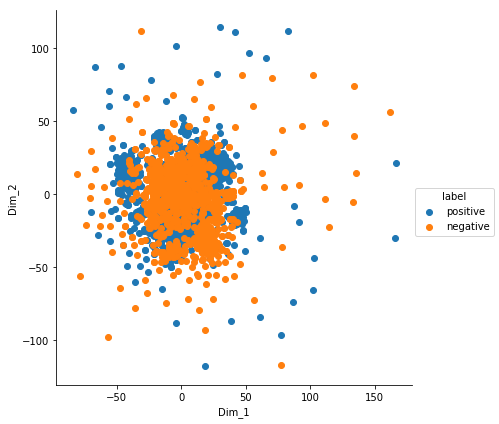

In [14]:
#final_DF: is the first 2000 vector representation of text reviews with 1000 positive and 1000 negative reviews
#positiveNegativeLabel is the label/class for each vector

#no need to init if done before.
#from sklearn.manifold import TSNE
#import seaborn as sn
#import matplotlib.pyplot as plt

model = TSNE(n_components=2, random_state=0, perplexity=30.0, learning_rate=200.0, n_iter=2000)
# configuring the parameteres
# the number of components = 23000
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(TFIDF_final_DF)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, positiveNegativeLabel)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Result
The TSNE visualization of TF-IDF vector is also not suitable to seperate out positive and negative reviews.
The TSNE visulaization was checked for various perplexity and iteration but there was no improvement on the result

## Text To Vector Conversion Using Average Word2Vec

### Making Our Own Word2vec Model
#### Using Google's Model Is Computationally Impossible In The System Where This Notebook Was Written

In [5]:
# Train our own Word2Vec model using your own text corpus
list_of_sent = []
import gensim
for sent in cleanedData_less['Text'].values:
    filtered_sentence=[]
    for w in sent.split():
        filtered_sentence.append(w.lower())
    list_of_sent.append(filtered_sentence)

print(cleanedData_less['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])
print(type(list_of_sent))

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
*****************************************************************
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud.', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', "we're", 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain.', "he's", 'learned', 'about', 'whales,', 'india,', 'drooping', 'roses:', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all.', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', '

In [6]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
print(len(words))

3367


In [9]:
#testing the w2v model
w2v_model.wv.most_similar('tasty')

[('sweet', 0.9986681938171387),
 ('nice', 0.9986587762832642),
 ('long', 0.9986510276794434),
 ('quite', 0.9986407160758972),
 ('close', 0.998633623123169),
 ('its', 0.9986270666122437),
 ('tea.', 0.9986125230789185),
 ('hard', 0.998579740524292),
 ('strong', 0.9985781908035278),
 ('high', 0.9985780119895935)]

In [10]:
w2v_model.wv.most_similar('like')

[('but', 0.9986637830734253),
 ('need', 0.9982534646987915),
 ('sure', 0.9976886510848999),
 ('buy', 0.9975889325141907),
 ('something', 0.9974557757377625),
 ('just', 0.9973907470703125),
 ("won't", 0.9973685145378113),
 ('what', 0.9972780346870422),
 ('may', 0.9972291588783264),
 ('unless', 0.9971435070037842)]

#### It appears that our word2vec model is not satisfactory. It is eveident from the choice of similar words being output for words like 'like' and 'tasty'. We will still go ahead with the t-SNE visualization but we cannot expect much improvement over BOW and TF-IDF

### Text to vector using average word2vec

In [15]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


##  Applying t-SNE on Average Word2Vec Vectors

In [16]:
#converting the list to dataframe
type(sent_vectors)
sent_vectors = pd.DataFrame(sent_vectors)
sent_vectors.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.199371,-0.732223,0.278914,0.382851,0.264534,-0.305687,-0.123939,-0.558129,-0.043099,-0.198820,...,0.050585,0.287017,0.226719,0.126691,0.035348,-0.647324,-0.176493,-0.166094,0.027026,0.284459
1,0.193424,-0.690376,0.272138,0.359390,0.268182,-0.292537,-0.141372,-0.510109,-0.020863,-0.173566,...,0.063936,0.283286,0.222009,0.123916,0.029411,-0.608879,-0.153370,-0.137285,0.030364,0.270880


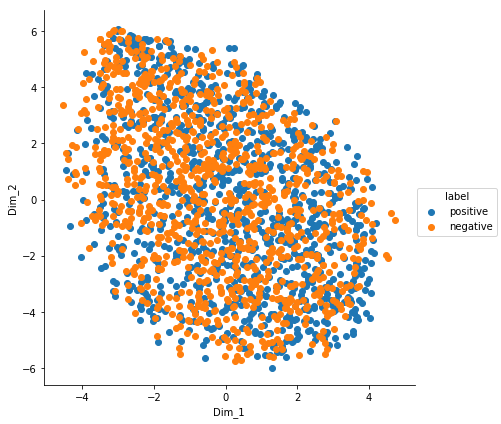

In [21]:

#this inits are not required if other TSNE were run before in same session
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt

model = TSNE(n_components=2, random_state=0, perplexity=700.0, learning_rate=200.0, n_iter=8000)
# configuring the parameteres
# the number of components = 23000
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, positiveNegativeLabel)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Result
The TSNE visualization of Average W2V is not suitable to seperate out positive and negative reviews.
The result had no improvement when perprexily and iterations were changed

## Text To Vector Using TF-IDF (Bigram) weighted Word2Vec


In [7]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(cleanedData_less['Text'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
len(tfidf_sent_vectors)

2000

##  Applying t-SNE on TF-IDF Weighted Word2Vec

In [8]:
#converting the list to dataframe 
tfidf_sent_vectors = pd.DataFrame(tfidf_sent_vectors)
tfidf_sent_vectors.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.350486,0.021644,-0.430442,-0.355413,0.094895,0.616877,0.385654,0.044370,-0.195837,0.327982,...,-0.100267,-0.394197,-0.282464,1.038122,-0.223706,0.120791,0.199385,0.356576,0.011207,0.053032
1,-0.364961,0.017636,-0.434947,-0.371138,0.065181,0.636542,0.384400,0.049116,-0.203098,0.337592,...,-0.092643,-0.398757,-0.318224,1.110455,-0.231025,0.130567,0.213189,0.384917,0.000604,0.070902


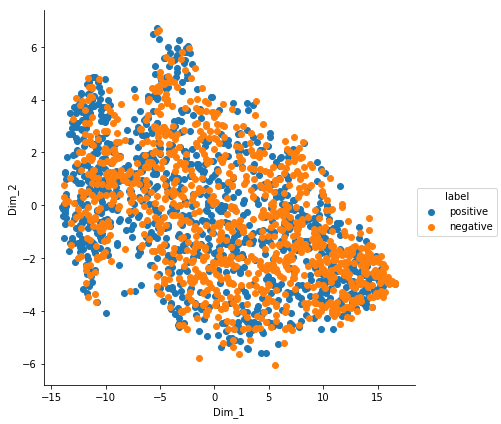

In [10]:
#Need to uncomment the 3 lines below if this t-SNE is the first execution in this notebook
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt

model = TSNE(n_components=2, random_state=0, perplexity=300.0, learning_rate=900.0, n_iter=2000)
# configuring the parameteres
# the number of components = 23000
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tfidf_sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, positiveNegativeLabel)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

### Result
The TSNE visualization of TFIDF weighted W2V vector is not suitable to seperate out positive and negative reviews
The result had no improvemnt when different perplexity and iteration values were tried

## Conclusion
The intended results were not achieved. The expection was to visually seperate out the positive and negative reviews. There are two probable causes for this failure:
1. Only 2k points were taken, instead of 364k, i.e. only 0.5% of the total dataset. There is a very high probability that the  TSNE visualization could be misleading with only 0.5% of total data
2. Our own model on word2vec was unsatisfctory. This became evident when we tried to see similar words for certain words like 'tasty'.

#### Takeaway
T-SNE graph with lots of overlapping data means that our classifier will perform badly on these 2k data points